# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [10]:
from netml.pparser.parser import PCAP
import pandas as pd
netflix = PCAP('netflix.pcap')
netflix.pcap2pandas()
data = netflix.df

In [11]:
data.head()

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,55697.0,UDP,1518358200.534682,0.000000
1,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,59884.0,UDP,1518358200.534832,0.000150
2,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,61223.0,UDP,1518358200.539408,0.004726
3,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,58785.0,UDP,1518358200.541204,0.006522
4,2018-02-11 08:10:00,"(ytimg.l.google.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,51938.0,UDP,1518358200.545785,0.011103


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [12]:
NF_DOMAINS = (["nflxvideo", "netflix", "nflxso", "nflxext"])
dns_data = data[data["is_dns"] == True]
netflix_dns = dns_data[dns_data["dns_query"].astype(str).apply(
        lambda x: any(domain in x.lower() for domain in NF_DOMAINS))]
netflix_ips = netflix_dns["dns_resp"].unique()
netflix_ips = [ip for ip in netflix_ips if pd.notnull(ip) and ip != "None"]
netflix_ips = [ip[0] for ip in netflix_ips if ip and ip[0] not in (None, 'None')]
netflix_traffic = data[
    (data["ip_dst"].isin(netflix_ips)) | (data["ip_src"].isin(netflix_ips))
]
netflix_traffic.head()

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
107,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58451.0,TCP,1518358202.903273,2.368591
109,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58452.0,TCP,1518358202.903319,2.368637
110,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58453.0,TCP,1518358202.903415,2.368733
112,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58454.0,TCP,1518358202.903625,2.368943
113,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58455.0,TCP,1518358202.903688,2.369006


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [13]:
netflix_traffic["flow_id"] = (
    netflix_traffic["ip_src"].astype(str)
    + "-" + netflix_traffic["ip_dst"].astype(str)
    + "-" + netflix_traffic["port_src"].astype(str)
    + "-" + netflix_traffic["port_dst"].astype(str)
    + "-" + netflix_traffic["protocol"].astype(str)
)
netflix_traffic = netflix_traffic.sort_values(["flow_id", "datetime"])
netflix_traffic["iat"] = netflix_traffic.groupby("flow_id")["datetime"].diff().dt.total_seconds()
netflix_features = (
    netflix_traffic.groupby("flow_id")
    .agg(
        ip_src=("ip_src", "first"),
        ip_dst=("ip_dst", "first"),
        port_src=("port_src", "first"),
        port_dst=("port_dst", "first"),
        protocol=("protocol", "first"),
        num_packets=("length", "count"),
        total_bytes=("length", "sum"),
        avg_pkt_size=("length", "mean"),
        std_pkt_size=("length", "std"),
        min_pkt_size=("length", "min"),
        max_pkt_size=("length", "max"),
        start_time=("datetime", "min"),
        end_time=("datetime", "max"),
        mean_iat=("iat", "mean"),
        std_iat=("iat", "std"),
        min_iat=("iat", "min"),
        max_iat=("iat", "max"),
    )
    .reset_index()
)
netflix_features["duration_sec"] = (
    netflix_features["end_time"] - netflix_features["start_time"]
).dt.total_seconds().clip(lower=1e-6)

netflix_features["pkts_per_sec"] = (
    netflix_features["num_packets"] / netflix_features["duration_sec"]
)

netflix_features["bytes_per_sec"] = (
    netflix_features["total_bytes"] / netflix_features["duration_sec"]
)

min_packets = 5
netflix_features = netflix_features[netflix_features["num_packets"] >= min_packets]

netflix_features.head()

/var/folders/00/2pj6l9592kq25pws768ymmt00000gn/T/ipykernel_12761/4158260141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_traffic["flow_id"] = (


,flow_id,ip_src,ip_dst,port_src,port_dst,protocol,num_packets,total_bytes,avg_pkt_size,std_pkt_size,...,max_pkt_size,start_time,end_time,mean_iat,std_iat,min_iat,max_iat,duration_sec,pkts_per_sec,bytes_per_sec
0,192.168.43.72-198.38.120.130-58451.0-443.0-TCP,192.168.43.72,198.38.120.130,58451.0,443.0,TCP,12,1064,88.666667,50.281631,...,200,2018-02-11 08:10:02,2018-02-11 08:10:17,1.363636,2.377929,0.0,8.0,15.0,0.800000,70.933333
1,192.168.43.72-198.38.120.130-58452.0-443.0-TCP,192.168.43.72,198.38.120.130,58452.0,443.0,TCP,11,998,90.727273,52.201707,...,200,2018-02-11 08:10:02,2018-02-11 08:10:17,1.500000,2.798809,0.0,9.0,15.0,0.733333,66.533333
2,192.168.43.72-198.38.120.130-58453.0-443.0-TCP,192.168.43.72,198.38.120.130,58453.0,443.0,TCP,12,1064,88.666667,50.281631,...,200,2018-02-11 08:10:02,2018-02-11 08:10:17,1.363636,2.377929,0.0,8.0,15.0,0.800000,70.933333
3,192.168.43.72-198.38.120.130-58480.0-443.0-TCP,192.168.43.72,198.38.120.130,58480.0,443.0,TCP,5,342,68.400000,5.366563,...,78,2018-02-11 08:10:03,2018-02-11 08:10:20,4.250000,7.847505,0.0,16.0,17.0,0.294118,20.117647
4,192.168.43.72-198.38.120.134-58496.0-443.0-TCP,192.168.43.72,198.38.120.134,58496.0,443.0,TCP,52,3826,73.576923,31.025193,...,200,2018-02-11 08:10:20,2018-02-11 08:11:21,1.196078,6.902230,0.0,49.0,61.0,0.852459,62.721311


**Write a brief justification for the features that you have chosen.**

The selected flow-level features capture both the volume and temporal behavior of Netflix traffic. The total number of packets (num_packets) and total bytes (total_bytes) describe the overall scale of each flow, while the average packet size (avg_pkt_size) reflects the typical data unit transmitted — often larger for video content and smaller for control messages.The flow duration (duration_sec) provides a temporal scope, and when combined with packet and byte counts, enables derived rate measures such as packets per second (pkts_per_sec) and bytes per second (bytes_per_sec), both of which are key indicators of throughput and data intensity. Finally, the mean and standard deviation of inter-arrival times (mean_iat, std_iat) summarize flow timing regularity: low variability suggests steady streaming, whereas high variability may indicate buffering or adaptive bitrate adjustments. Together, these features provide a concise yet comprehensive representation of each flow’s traffic characteristics, balancing efficiency, rate, and temporal stability — all crucial for analyzing Netflix-like streaming patterns.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [ ]:
import numpy as np
window_size = 10  
netflix_traffic['time_bin'] = ((netflix_traffic['time'] - netflix_traffic['time'].min()) // window_size).astype(int)

segment_rate = (
    netflix_traffic.groupby('time_bin')
    .agg(segment_downloads=('length', 'count'))
    .reset_index()
)
segment_rate['segment_downloads_rate'] = segment_rate['segment_downloads'] / window_size

flow_segment_rate = (
    netflix_traffic.merge(segment_rate[['time_bin', 'segment_downloads_rate']],
                          on='time_bin', how='left')
    .groupby('ip_dst')
    .agg(
        segment_rate_mean=('segment_downloads_rate', 'mean'),
        segment_rate_max=('segment_downloads_rate', 'max')
    )
    .reset_index()
)

flow_stats = netflix_features.merge(flow_segment_rate, on=['ip_dst'], how='left')
flow_stats.head()

,flow_id,ip_src,ip_dst,port_src,port_dst,protocol,num_packets,total_bytes,avg_pkt_size,std_pkt_size,...,end_time,mean_iat,std_iat,min_iat,max_iat,duration_sec,pkts_per_sec,bytes_per_sec,segment_rate_mean,segment_rate_max
0,192.168.43.72-198.38.120.130-58451.0-443.0-TCP,192.168.43.72,198.38.120.130,58451.0,443.0,TCP,12,1064,88.666667,50.281631,...,2018-02-11 08:10:17,1.363636,2.377929,0.0,8.0,15.0,0.800000,70.933333,56.710000,57.1
1,192.168.43.72-198.38.120.130-58452.0-443.0-TCP,192.168.43.72,198.38.120.130,58452.0,443.0,TCP,11,998,90.727273,52.201707,...,2018-02-11 08:10:17,1.500000,2.798809,0.0,9.0,15.0,0.733333,66.533333,56.710000,57.1
2,192.168.43.72-198.38.120.130-58453.0-443.0-TCP,192.168.43.72,198.38.120.130,58453.0,443.0,TCP,12,1064,88.666667,50.281631,...,2018-02-11 08:10:17,1.363636,2.377929,0.0,8.0,15.0,0.800000,70.933333,56.710000,57.1
3,192.168.43.72-198.38.120.130-58480.0-443.0-TCP,192.168.43.72,198.38.120.130,58480.0,443.0,TCP,5,342,68.400000,5.366563,...,2018-02-11 08:10:20,4.250000,7.847505,0.0,16.0,17.0,0.294118,20.117647,56.710000,57.1
4,192.168.43.72-198.38.120.134-58496.0-443.0-TCP,192.168.43.72,198.38.120.134,58496.0,443.0,TCP,52,3826,73.576923,31.025193,...,2018-02-11 08:11:21,1.196078,6.902230,0.0,49.0,61.0,0.852459,62.721311,191.246154,1820.8


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [17]:
import pickle
with open('netflix_dataset.pkl', 'rb') as f:
    netflix_dataset = pickle.load(f)

netflix_dataset.head()

/var/folders/00/2pj6l9592kq25pws768ymmt00000gn/T/ipykernel_12761/129251644.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  netflix_dataset = pickle.load(f)


,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [18]:
resolutions = [240, 360, 480, 720, 1080]
netflix_dataset = netflix_dataset[netflix_dataset['resolution'].isin(resolutions)]
netflix_dataset.head()

,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [19]:
print(list(netflix_dataset.columns))

['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'absolute_timestamp', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev', 'access_var', 'ads', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_50R', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_75R', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_prev_up_chunk_iat_90', 'all_prev_up_chunk_iat_90R',

In [20]:
id_cols = [
    'index',
    'session_id',
    'deployment_session_id',
    'home_id',
    'video_id',
    'service',  
    'service_Video_throughput_down',
    'service_Video_throughput_up',
    'service_non_video_throughput_down',
    'service_non_video_throughput_up',
]
time_cols = [
    'absolute_timestamp',
    'relative_timestamp',
    'chunk_start_time',
    'chunk_end_time',
    'video_position',
    'startup_time',
]
leakage_cols = [
    'cumsum_chunksizes',
    'cumsum_diff',
    'size_diff_previous'
]
redundant_cols = [
    c for c in data.columns if c.endswith('R')
]
drop_cols = id_cols + time_cols + leakage_cols + redundant_cols
clean_dataset = netflix_dataset.drop(columns=drop_cols)
clean_dataset.head()

,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userThroughput,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0.0,0,0.108730,0.557937,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0.0,0,0.116865,0.549802,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0.0,0,0.126852,0.539815,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0.0,0,0.186111,0.480556,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0.0,0,0.194444,0.472222,False,False,False,False,12.0


**Briefly explain why you removed those columns.**

I removed those columns because they contained only missing or constant values, identifiers (like IDs and timestamps) that don’t help prediction, or redundant features that don’t provide meaningful variation for the model.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

y = clean_dataset['quality']  

leaky_features = [
    'resolution',  
    'c_rebufferings', 'n_rebufferings', 
    'bitrate_change', 'previous_bitrate', 
    'c_bitrate_switches', 'n_bitrate_switches', 
    'c_resolution_switches',  
    'curr_chunksize', 
    'video_duration',  
]

X = clean_dataset.drop(columns=[
    'quality', 'bitrate', 'video_id', 'session_id',
    'deployment_session_id', 'absolute_timestamp', 'relative_timestamp'
] + leaky_features, errors='ignore')

print(f"Removed {len(leaky_features)} potentially leaky features")
print(f"Leaky features removed: {[f for f in leaky_features if f in clean_dataset.columns]}\n")

# Check for columns with non-scalar values (arrays/lists)
cols_to_drop = []
for col in X.columns:
    sample_val = X[col].iloc[0]
    if isinstance(sample_val, (list, np.ndarray)):
        cols_to_drop.append(col)
        print(f"Dropping column '{col}' (contains arrays/lists)")
X = X.drop(columns=cols_to_drop)

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"\nFinal feature count: {len(numeric_cols) + len(categorical_cols)}")
print(f"  - Numeric features: {len(numeric_cols)}")
print(f"  - Categorical features: {len(categorical_cols)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() < 10 else None
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

print(f"\nPreprocessed training set shape: {X_train_prepared.shape}")
print(f"Preprocessed testing set shape: {X_test_prepared.shape}")

Removed 10 potentially leaky features
Leaky features removed: ['resolution', 'c_rebufferings', 'n_rebufferings', 'bitrate_change', 'previous_bitrate', 'c_bitrate_switches', 'n_bitrate_switches', 'c_resolution_switches', 'curr_chunksize', 'video_duration']

Dropping column '10_EWMA_chunksizes' (contains arrays/lists)

Final feature count: 219
  - Numeric features: 213
  - Categorical features: 6

Preprocessed training set shape: (39798, 224)
Preprocessed testing set shape: (9950, 224)


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest model...")
rf_model.fit(X_train_prepared, y_train)
print("Training complete!")

y_train_pred = rf_model.predict(X_train_prepared)
y_test_pred = rf_model.predict(X_test_prepared)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Training complete!

Training Accuracy: 0.9972
Test Accuracy: 0.9764

Test Set Classification Report:
              precision    recall  f1-score   support

         bad       0.97      0.99      0.98      7130
        good       0.98      0.93      0.96      2820

    accuracy                           0.98      9950
   macro avg       0.98      0.96      0.97      9950
weighted avg       0.98      0.98      0.98      9950



### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

print("Starting hyperparameter tuning with RandomizedSearchCV...")
print("This may take a few minutes...\n")

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=20,  # number of parameter combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_prepared, y_train)

print("\n" + "="*50)
print("BEST HYPERPARAMETERS FOUND:")
print("="*50)
print(random_search.best_params_)

print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS:")
print("="*50)
print(f"Best CV Score: {random_search.best_score_:.4f}")

best_rf_model = random_search.best_estimator_

y_test_pred_tuned = best_rf_model.predict(X_test_prepared)
test_accuracy_tuned = accuracy_score(y_test, y_test_pred_tuned)

print(f"\nTest Accuracy (Tuned Model): {test_accuracy_tuned:.4f}")

print("\n" + "="*50)
print("TOP 5 PARAMETER COMBINATIONS:")
print("="*50)
results_df = pd.DataFrame(random_search.cv_results_)
top_5 = results_df.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_5.iterrows():
    print(f"\nRank {row.name + 1}:")
    print(f"  Parameters: {row['params']}")
    print(f"  Mean CV Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")

Starting hyperparameter tuning with RandomizedSearchCV...
This may take a few minutes...

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   9.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   9.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   9.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   9.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   9.9s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  12.7s
[CV] END bootstrap=False, max_d

/Users/apple/Documents/CMSC 25422/video-quality-of-experience-jianghui-chen/venv/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



BEST HYPERPARAMETERS FOUND:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

CROSS-VALIDATION RESULTS:
Best CV Score: 0.9793

Test Accuracy (Tuned Model): 0.9828

TOP 5 PARAMETER COMBINATIONS:

Rank 17:
  Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
  Mean CV Score: 0.9793 (+/- 0.0010)

Rank 6:
  Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
  Mean CV Score: 0.9786 (+/- 0.0009)

Rank 5:
  Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
  Mean CV Score: 0.9786 (+/- 0.0013)

Rank 14:
  Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': 

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

MODEL EVALUATION METRICS

1. ACCURACY: 0.9828 (98.28%)

2. F1 SCORES:
   - F1 Score (positive='good'): 0.9691
   - F1 Score (weighted): 0.9827
   - F1 Score (macro): 0.9786

3. CONFUSION MATRIX:
[[7094   36]
 [ 135 2685]]


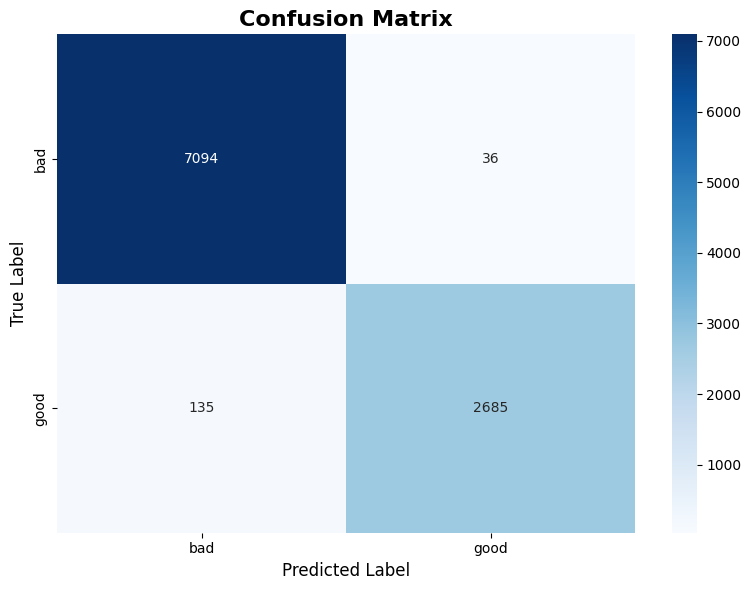


   True Negatives (TN): 7094
   False Positives (FP): 36
   False Negatives (FN): 135
   True Positives (TP): 2685

   Precision (good): 0.9868
   Recall (good): 0.9521
   Specificity (bad): 0.9950

4. ROC AUC SCORE: 0.9978


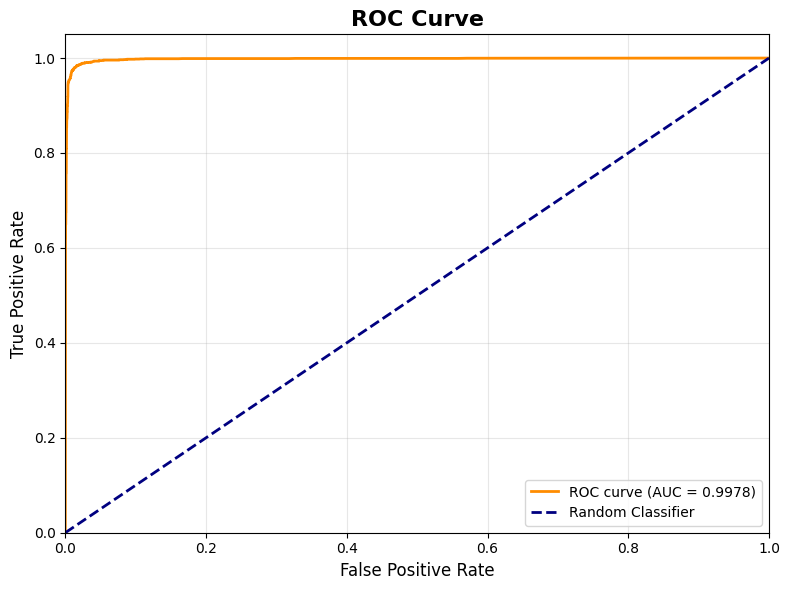


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

         bad     0.9813    0.9950    0.9881      7130
        good     0.9868    0.9521    0.9691      2820

    accuracy                         0.9828      9950
   macro avg     0.9840    0.9735    0.9786      9950
weighted avg     0.9829    0.9828    0.9827      9950



In [ ]:
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = best_rf_model.predict(X_test_prepared)
y_pred_proba = best_rf_model.predict_proba(X_test_prepared)

print("MODEL EVALUATION METRICS")

# 1. ACCURACY
accuracy = accuracy_score(y_test, y_pred)
print(f"\n1. ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 2. F1 SCORE
f1_binary = f1_score(y_test, y_pred, pos_label='good')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\n2. F1 SCORES:")
print(f"   - F1 Score (positive='good'): {f1_binary:.4f}")
print(f"   - F1 Score (weighted): {f1_weighted:.4f}")
print(f"   - F1 Score (macro): {f1_macro:.4f}")

# 3. CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
print(f"\n3. CONFUSION MATRIX:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bad', 'good'], 
            yticklabels=['bad', 'good'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\n   True Negatives (TN): {tn}")
print(f"   False Positives (FP): {fp}")
print(f"   False Negatives (FN): {fn}")
print(f"   True Positives (TP): {tp}")
print(f"\n   Precision (good): {tp/(tp+fp):.4f}")
print(f"   Recall (good): {tp/(tp+fn):.4f}")
print(f"   Specificity (bad): {tn/(tn+fp):.4f}")

# 4. ROC/AUC
class_labels = best_rf_model.classes_
good_idx = list(class_labels).index('good')
y_pred_proba_good = y_pred_proba[:, good_idx]

y_test_binary = (y_test == 'good').astype(int)

roc_auc = roc_auc_score(y_test_binary, y_pred_proba_good)
print(f"\n4. ROC AUC SCORE: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba_good)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, digits=4))

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

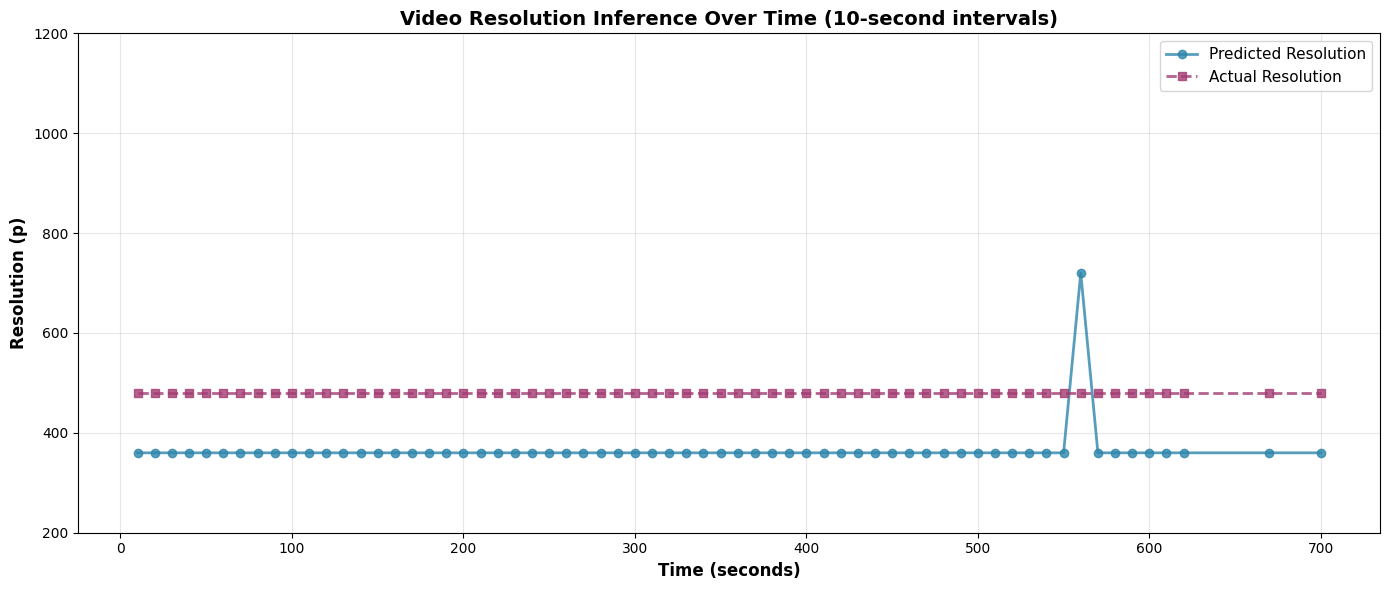

INFERENCE SUMMARY
Total time bins: 64
Time range: 10s - 700s
Duration: 690 seconds

Prediction accuracy over time: 100.00%
Correct predictions: 64/64

PREDICTED RESOLUTION DISTRIBUTION
predicted_resolution
360    63
720     1
Name: count, dtype: int64

ACTUAL RESOLUTION DISTRIBUTION
actual_resolution
480.0    64
Name: count, dtype: int64


In [ ]:
# Test split used as the preprocessed data

test_indices = X_test.index

test_data_with_metadata = netflix_dataset.loc[test_indices].copy()

if 'relative_timestamp' in netflix_dataset.columns:
    time_col = 'relative_timestamp'
elif 'absolute_timestamp' in netflix_dataset.columns:
    time_col = 'absolute_timestamp'
elif 'chunk_start_time' in netflix_dataset.columns:
    time_col = 'chunk_start_time'
else:
    print("Warning: No timestamp column found. Creating synthetic time intervals.")
    test_data_with_metadata['time'] = np.arange(len(test_data_with_metadata)) * 10
    time_col = 'time'

y_pred_quality = best_rf_model.predict(X_test_prepared)

test_data_with_metadata['predicted_quality'] = y_pred_quality
test_data_with_metadata['actual_quality'] = y_test.values

if 'resolution' in test_data_with_metadata.columns:
    test_data_with_metadata['actual_resolution'] = test_data_with_metadata['resolution']
else:
    test_data_with_metadata['actual_resolution'] = test_data_with_metadata['actual_quality'].map({
        'good': 720,
        'bad': 360
    })

test_data_with_metadata['predicted_resolution'] = test_data_with_metadata['predicted_quality'].map({
    'good': 720,
    'bad': 360
})

test_data_with_metadata = test_data_with_metadata.sort_values(time_col).reset_index(drop=True)

# Create time bins of 10 seconds
if time_col in ['relative_timestamp', 'chunk_start_time']:
    test_data_with_metadata['time_seconds'] = test_data_with_metadata[time_col]
elif time_col == 'absolute_timestamp':
    test_data_with_metadata['time_seconds'] = (
        test_data_with_metadata[time_col] - test_data_with_metadata[time_col].min()
    )
else:
    test_data_with_metadata['time_seconds'] = test_data_with_metadata['time']

test_data_with_metadata['time_bin'] = (test_data_with_metadata['time_seconds'] // 10) * 10

resolution_over_time = test_data_with_metadata.groupby('time_bin').agg({
    'predicted_resolution': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'actual_resolution': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'predicted_quality': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'actual_quality': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(resolution_over_time['time_bin'], 
         resolution_over_time['predicted_resolution'], 
         marker='o', linestyle='-', linewidth=2, markersize=6,
         label='Predicted Resolution', color='#2E86AB', alpha=0.8)
ax.plot(resolution_over_time['time_bin'], 
         resolution_over_time['actual_resolution'], 
         marker='s', linestyle='--', linewidth=2, markersize=6,
         label='Actual Resolution', color='#A23B72', alpha=0.8)
ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Resolution (p)', fontsize=12, fontweight='bold')
ax.set_title('Video Resolution Inference Over Time (10-second intervals)', 
              fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([200, 1200])

plt.tight_layout()
plt.show()

print("="*60)
print("INFERENCE SUMMARY")
print("="*60)
print(f"Total time bins: {len(resolution_over_time)}")
print(f"Time range: {resolution_over_time['time_bin'].min():.0f}s - {resolution_over_time['time_bin'].max():.0f}s")
print(f"Duration: {(resolution_over_time['time_bin'].max() - resolution_over_time['time_bin'].min()):.0f} seconds")

# Calculate accuracy over time
correct_predictions = (resolution_over_time['predicted_quality'] == resolution_over_time['actual_quality']).sum()
total_predictions = len(resolution_over_time)
accuracy = correct_predictions / total_predictions

print(f"\nPrediction accuracy over time: {accuracy:.2%}")
print(f"Correct predictions: {correct_predictions}/{total_predictions}")

# Show distribution of predicted resolutions
print("\n" + "="*60)
print("PREDICTED RESOLUTION DISTRIBUTION")
print("="*60)
print(resolution_over_time['predicted_resolution'].value_counts().sort_index())

print("\n" + "="*60)
print("ACTUAL RESOLUTION DISTRIBUTION")
print("="*60)
print(resolution_over_time['actual_resolution'].value_counts().sort_index())